# 实验一期末复习：中国股市收益率的分布特征

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat # 加载matlab数据文件
from scipy.stats import norm # 正太分布

In [2]:
plt.rcParams.update(
    {
        'font.family': 'STIXGeneral', # 字体
        'font.size': 20,  # 字号
        'mathtext.fontset': 'cm', # 数学文本字体
    }
)

## 对上证指数的日收益率进行经验分布和正太分布的拟合

In [3]:
ssec_daily = pd.read_csv('../../实验一/data/1LShowData_SSEC_daily.csv', encoding='gbk')
ssec_daily

,指数代码,指数名称,交易日期,开盘,最高,最低,收盘,成交量,成交金额
0,1,上证指数,1997/1/2,914.06,920.19,909.46,919.44,265303700,2.369874e+09
1,1,上证指数,1997/1/3,921.10,922.39,896.99,899.61,342916500,2.822564e+09
2,1,上证指数,1997/1/6,890.98,892.02,875.89,876.50,241608800,1.894047e+09
3,1,上证指数,1997/1/7,872.81,903.00,871.78,898.17,251824800,1.963756e+09
4,1,上证指数,1997/1/8,899.83,902.53,887.23,896.41,231369000,1.880559e+09
...,...,...,...,...,...,...,...,...,...
5086,1,上证指数,2017/12/29,3295.25,3308.22,3292.77,3307.17,14158683600,1.703570e+11
5087,1,上证指数,2018/1/2,3314.03,3349.05,3314.03,3348.33,20227886000,2.277880e+11
5088,1,上证指数,2018/1/3,3347.74,3379.92,3345.29,3369.11,21383614900,2.583670e+11
5089,1,上证指数,2018/1/4,3371.00,3392.83,3365.30,3385.71,20695528800,2.430910e+11


In [4]:
# 加载和查看日度数据
# .values 将 pdSeries 转换成 ndarray
price_daily = ssec_daily['收盘'].values 
price_daily

array([ 919.44,  899.61,  876.5 , ..., 3369.11, 3385.71, 3391.75])

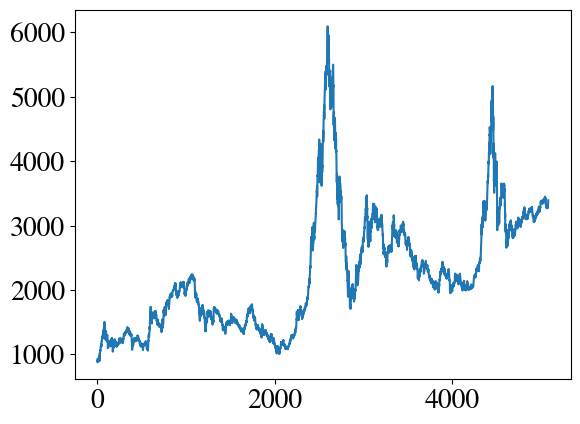

In [5]:
plt.plot(price_daily)

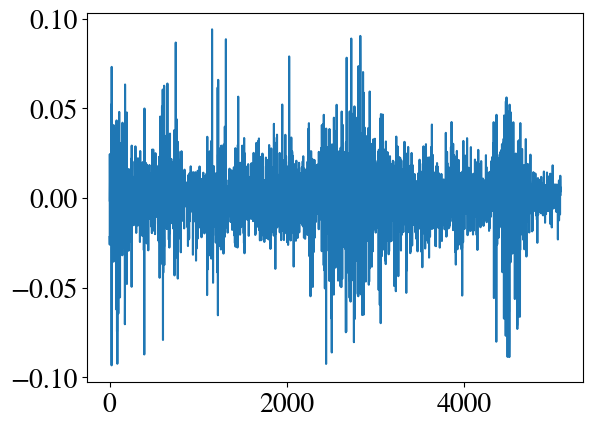

In [6]:
# 计算收益率 - 指数收益率
# [1:] 表示 从第二个元素（下标1）开始取到最后
# [:-1]表示 从开始取到倒数第一个元素（左闭右开所以取到倒数第二个）
# r_t = ln(P_t) - ln(P_{t-1})
r_daily = np.log(price_daily[1:]) - np.log(price_daily[:-1])
plt.plot(r_daily)

In [7]:
# 经验密度概率计算
# 例如，如果25%的数据落在0.1和0.2之间，那么PDF曲线在0.1到0.2之间的面积应该等于0.25。
def calc_emp(data, n):
    # np.linspace(a, b, n) 会生成 n 个在 [a, b] 区间上等间距的点
    # 这里就是把数据划分为n-1个等距区间
    bin = np.linspace(np.min(data), np.max(data), n)

    x_pdf = np.zeros(n-1)
    y_pdf = np.zeros(n-1)
    # 计算概率密度
    for i in range(n-1):
        x_pdf[i] = (bin[i] + bin[i+1]) / 2 # 区间中心

        y_pdf[i] = np.sum(
            (data >= bin[i]) & (data <= bin[i+1]) # 落入区间的data值
        ) / len(data) / (bin[i+1] - bin[i]) # 先除以数据点总数，得到比例，然后除以区间长度归一化
    
    return x_pdf, y_pdf

从数学角度看，这个函数计算的是：

对于区间 [bin_i, bin_{i+1}]：
- 区间中心 = (bin_i + bin_{i+1}) / 2
- 概率密度值 = P(bin_i ≤ X < bin_{i+1}) / (bin_{i+1} - bin_i)

其中 P(bin_i ≤ X < bin_{i+1}) 是随机变量 X 落在该区间的概率，通过 样本计数/总样本数 估计。

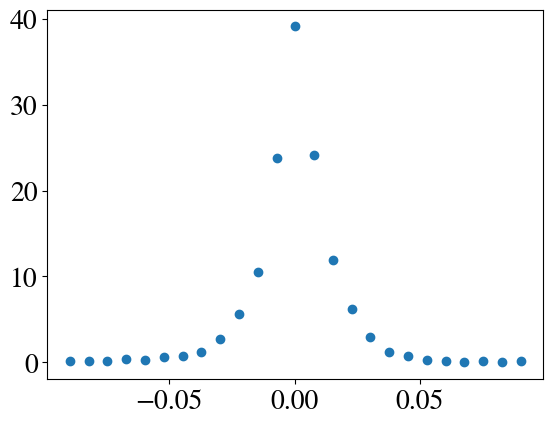

In [8]:
# 计算并绘制日度收益率的经验概率密度
# 这里将5000多个收益率分为25个区间
x_emp_daily, y_emp_daily = calc_emp(r_daily, 26)
plt.plot(x_emp_daily, y_emp_daily, 'o')

In [9]:
# 正太分布拟合
def calc_norm(data):
    mu, sigma = norm.fit(data) # 用最大似然估计拟合出符合样本数据的正态分布参数
    x_norm = np.linspace(np.min(data), np.max(data), 100) # 选100个均匀分布的点，便于画图
    y_norm = norm.pdf(x_norm, mu, sigma)

    return x_norm, y_norm

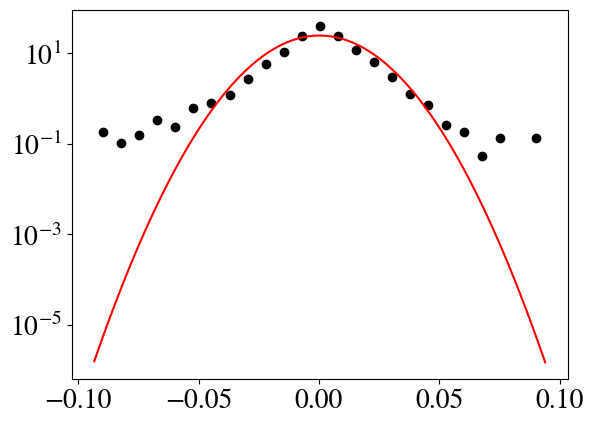

In [10]:
x_norm_daily, y_norm_daily = calc_norm(r_daily)

# 用半对数坐标（log-scale） 来绘制概率密度函数，y轴取对数，x轴保持线性
# 放大概率密度函数中非常小的值（尤其是尾部），让我们更容易看出数据分布是否具有 fat tail，从而判断其是否偏离正态分布。
"""
| 普通 plot（线性 y 轴）        | semilogy（对数 y 轴）         |
|--------------------------|----------------------------|
| 尾部几乎看不到            | 尾部细节清晰可见 |
| 更适合中间部分对比         | 更适合 tail behavior 分析 |
| 无法判断 fat-tail 行为  | 能看出是否 fat-tail（经验密度比正态更高） |
"""
plt.semilogy(x_emp_daily, y_emp_daily, 'ko') # black 原点
plt.semilogy(x_norm_daily, y_norm_daily, 'r-') # red 实线

## 处理分钟级数据

In [11]:
ssec_min = loadmat('../../实验一/data/SSEC_min.mat')
ssec_min

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Nov 22 00:48:21 2016',
 '__version__': '1.0',
 '__globals__': [],
 'd': array([[array(['2003-01-02'], dtype='<U10')],
        [array(['2003-01-03'], dtype='<U10')],
        [array(['2003-01-03'], dtype='<U10')],
        ...,
        [array(['2015/12/31'], dtype='<U10')],
        [array(['2015/12/31'], dtype='<U10')],
        [array(['2015/12/31'], dtype='<U10')]], dtype=object),
 'p': array([[1348.13 ],
        [1318.918],
        [1318.436],
        ...,
        [3539.522],
        [3539.596],
        [3539.182]]),
 't': array([[array(['10:30'], dtype='<U5')],
        [array(['13:12'], dtype='<U5')],
        [array(['14:56'], dtype='<U5')],
        ...,
        [array(['15:00'], dtype='<U5')],
        [array(['15:01'], dtype='<U5')],
        [array(['15:02'], dtype='<U5')]], dtype=object)}

数据包含日期('d')、价格('p')和时间('t')三个主要字段。

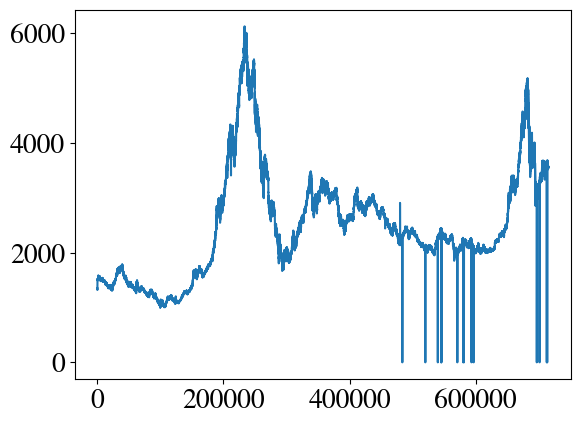

In [12]:
p_min = ssec_min['p'][:, 0] # 取所有行的第0列
plt.plot(p_min)

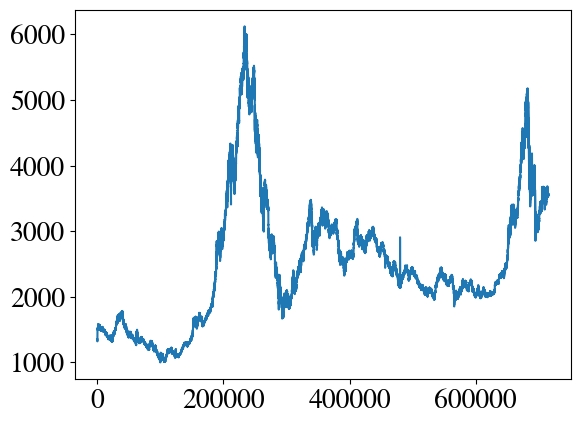

In [13]:
# 过滤掉异常值
p_filtered = p_min[p_min > 100]
plt.plot(p_filtered)

C:\Users\15170\AppData\Local\Temp\ipykernel_25232\3090622649.py:2: RuntimeWarning: divide by zero encountered in log
  r_min = np.log(p_min[1:]) - np.log(p_min[:-1])
C:\Users\15170\AppData\Local\Temp\ipykernel_25232\3090622649.py:2: RuntimeWarning: invalid value encountered in subtract
  r_min = np.log(p_min[1:]) - np.log(p_min[:-1])


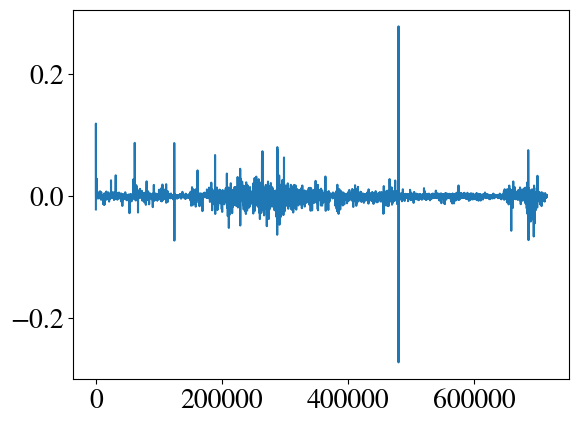

In [14]:
# 计算分钟级收益率并过滤异常值
r_min = np.log(p_min[1:]) - np.log(p_min[:-1])
plt.plot(r_min)

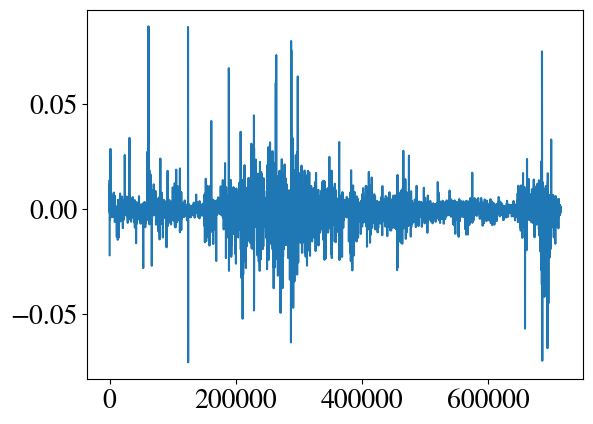

In [15]:
r_filtered = r_min[(r_min >= -0.1) & (r_min <= 0.1)]
plt.plot(r_filtered)

In [16]:
# 计算分钟级的经验概率和正太分布
x_emp_min, y_emp_min = calc_emp(r_filtered, 26)
x_norm_min, y_norm_min = calc_norm(r_filtered)

(0.0001, 1000)

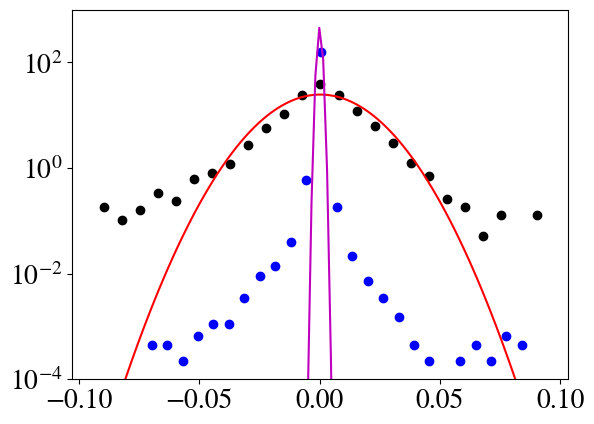

In [17]:
plt.semilogy(x_emp_daily, y_emp_daily, 'ko')
plt.semilogy(x_norm_daily, y_norm_daily, 'r-')
plt.semilogy(x_emp_min, y_emp_min, 'bo')
plt.semilogy(x_norm_min, y_norm_min, 'm-') # magenta, 品红色

plt.ylim([10**-4, 10**3]) # 设置y的范围

In [18]:
# 过滤掉概率密度等于0的点，log(=0)无意义
x_emp_daily = x_emp_daily[y_emp_daily > 0]
y_emp_daily = y_emp_daily[y_emp_daily > 0]
x_emp_min = x_emp_min[y_emp_min > 0]
y_emp_min = y_emp_min[y_emp_min > 0]

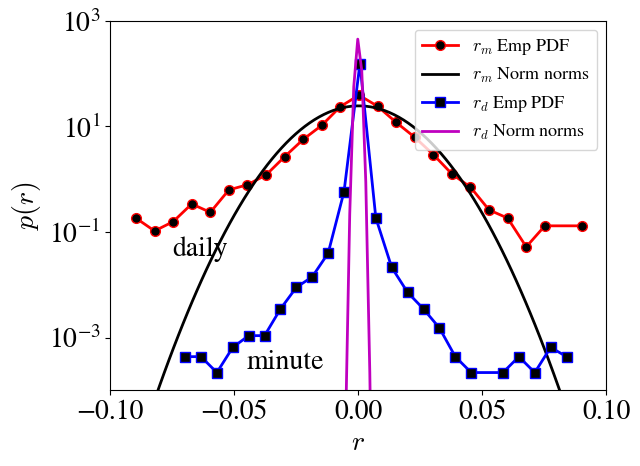

In [ ]:
plt.figure(1) # 创建一个新的图形窗口，编号为 1

# lw线宽，ms标记大小，mfc标记的填充颜色，label图例标签
plt.semilogy(x_emp_daily, y_emp_daily, 'o-r', lw=2, ms=7, mfc='k', label=r'$r_m$ Emp PDF')
plt.semilogy(x_norm_daily, y_norm_daily, '-k', lw=2, label=r'$r_m$ Norm norms')
plt.semilogy(x_emp_min, y_emp_min, 's-b', lw=2, ms=7, mfc='k', label=r'$r_d$ Emp PDF')
plt.semilogy(x_norm_min, y_norm_min, 'm-', lw=2, label=r'$r_d$ Norm norms')

plt.xlim([-0.1, 0.1])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1]) # x标记点
plt.ylim([10**-4, 10**3])
plt.yticks([10**-3, 10**-1, 10**1, 10**3])

plt.xlabel(r'$r$', fontsize=20)
plt.ylabel(r'$p(r)$', fontsize=20)
plt.text(-0.075, 0.035, 'daily', fontsize=20) # 在坐标 (−0.075,0.035) 处添加文本 daily，字体大小为 20
plt.text(-0.045, 0.00025, 'minute', fontsize=20)
plt.legend(loc='upper right', fontsize=13) # 添加图例，位置在图的右上角，字体大小为 13

plt.savefig('Fig1.pdf', dpi=600, bbox_inches='tight') # 裁剪图像以去除多余的空白区域（bbox_inches='tight'）